# Загрузка нужных библиотек

In [ ]:
!git clone https://github.com/huggingface/transformers
!pip install datasets
!cd transformers; python setup.py install

In [ ]:
import random, torch
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split

# Подготовка данных

In [ ]:
# Загружаем исходные данные из паркет-файла и выполняем небольшую предобработку
def replace_re(text, regexp, inplace): 
    return regexp.sub(inplace, text)

data = pd.read_parquet("data/data_fusion_train.parquet", columns=['item_name'])
data['item_name'] = data['item_name'].apply(lambda x: x.replace("\xa0", ' '))
regex_punc = re.compile('[%s]'%re.escape(string.punctuation+'№'+'╣'))
data['item_name'] = data['item_name'].apply(lambda x: replace_re(x, regex_punc, ' '))
regex_digits = re.compile('\d')
data['item_name'] = data['item_name'].apply(lambda x: replace_re(x, regex_digits, ' '))
data['item_name'] = data['item_name'].apply(lambda x: x.strip())
regex_seq_spaces = re.compile(' {2,}')
data['item_name'] = data['item_name'].apply(lambda x: replace_re(x, regex_seq_spaces, ' '))
data['item_name'] = data['item_name'].apply(lambda x: x.lower())
data = data[data.item_name != 'с собой']
data.drop_duplicates(inplace=True)

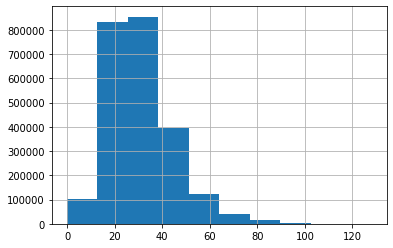

In [ ]:
data.item_name.apply(len).hist()

In [ ]:
# Оставим item_name, длина которых больше 16 символы
data = data[data.item_name.apply(len) > 16]
data.shape

(2091992, 1)

In [ ]:
!mkdir mlm1500000

In [ ]:
# Создаем тренировочный и тестовый датасет для обучения модели
# Выбираем 1500000 item_name
data = data.sample(1500000, random_state=17)
X_train, X_test = train_test_split(data[['item_name']], test_size=.2, random_state=SEED)
X_test.to_csv('mlm1500000/test.txt', index=False, header=False)
X_train.to_csv('mlm1500000/train.txt', index=False, header=False)

# Дообучение модели (задача языкового моделирования)

На карточке Tesla T4 дообучение модели на 1500000 item_name заняло примерно 6 часов. 

In [ ]:
!cd transformers/examples/language-modeling; python run_mlm.py --model_name_or_path distilbert-base-multilingual-cased --model_type distilbert --train_file mlm1500000/train.txt --validation_file mlm1500000/test.txt --do_train --do_eval --output_dir mlm1500000 --overwrite_output_dir